In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LeakyReLU
from keras import backend
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# Hyperparams
n_units = 400
layers = 4
n_batch = 1024
n_epochs = 200

In [4]:
df = pd.read_csv('../options-df-sigma.csv')
df = df.dropna(axis=0)
df = df.drop(columns=['date', 'exdate', 'impl_volatility'])
df.strike_price = df.strike_price / 1000
call_df = df[df.cp_flag == 'C'].drop(['cp_flag'], axis=1)
put_df = df[df.cp_flag == 'P'].drop(['cp_flag'], axis=1)

In [5]:
call_X_train, call_X_test, call_y_train, call_y_test = train_test_split(call_df.drop(['best_bid', 'best_offer'], axis=1),
                                                                        (call_df.best_bid + call_df.best_offer) / 2,
                                                                        test_size=0.01, random_state=42)
put_X_train, put_X_test, put_y_train, put_y_test = train_test_split(put_df.drop(['best_bid', 'best_offer'], axis=1),
                                                                    (put_df.best_bid + put_df.best_offer) / 2,
                                                                    test_size=0.01, random_state=42)

In [6]:
from keras.models import load_model
model = load_model('mlp1-120.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [8]:
call_y_test_mlp = model.predict(call_X_test)

In [12]:
from scipy.stats import norm
def black_scholes(row):
    S = row.closing_price
    X = row.strike_price
    T = row.date_ndiff / 365
    r = row.treasury_rate / 100
    σ = row.sigma_20
    d1 = (np.log(S / X) + (r + (σ ** 2) / 2) * T) / (σ * (T ** .5))
    d2 = d1 - σ * (T ** .5)
    C = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return C

In [13]:
call_X_test.head()

,strike_price,volume,open_interest,date_ndiff,treasury_rate,closing_price,sigma_20
307405,1450.0,50,29356,115,4.67,1253.41,0.014233
6204720,1325.0,0,0,7,0.00,2102.31,0.005663
1841257,720.0,113,37,45,0.15,712.87,0.024357
3004299,1270.0,141,22206,16,0.02,1244.58,0.018187
8365934,2020.0,0,1,26,0.26,2132.98,0.006238


In [14]:
call_y_test_bs = black_scholes(call_X_test)

In [17]:
'test set mse mlp', np.mean(np.square(call_y_test - np.reshape(call_y_test_mlp, call_y_test_mlp.shape[0])))

('test set mse mlp', 53.54766942533657)

In [16]:
'test set mse bs', np.mean(np.square(call_y_test - np.reshape(call_y_test_bs, call_y_test_bs.shape[0])))

('test set mse bs', 725.6104518624826)

In [18]:
call_y_train_mlp = model.predict(call_X_train)
call_y_train_bs = black_scholes(call_X_train)

In [34]:
'train set mse mlp', np.mean(np.square(call_y_train - np.reshape(call_y_train_mlp, call_y_train_mlp.shape[0])))

('train set mse mlp', 53.07852645913434)

In [35]:
'tain set mse bs', np.mean(np.square(call_y_train - np.reshape(call_y_train_bs, call_y_train_bs.shape[0])))

('tain set mse bs', 716.2958847874012)

In [ ]:
np.mean((call_y_test - np.reshape(call_y_test_bs, call_y_test_bs.shape[0])) / call_y_test)

In [64]:
'bs aape', 100 * np.mean(np.abs((call_y_test - np.reshape(call_y_test_bs, call_y_test_bs.shape[0])) / call_y_test))

('bs aape', 41.33787526826092)

In [65]:
'mlp aape', 100 * np.mean(np.abs((call_y_test - np.reshape(call_y_test_mlp, call_y_test_mlp.shape[0])) / call_y_test))

('mlp aape', 30.107287819609073)

In [67]:
'bs mape', 100 * np.median(np.abs((call_y_test - np.reshape(call_y_test_bs, call_y_test_bs.shape[0])) / call_y_test))

('bs mape', 9.563151854895564)

In [68]:
'mlp mape', 100 * np.median(np.abs((call_y_test - np.reshape(call_y_test_mlp, call_y_test_mlp.shape[0])) / call_y_test))

('mlp mape', 3.0082747002339314)

In [38]:
'bs median percent error', 100 * np.median((call_y_test - np.reshape(call_y_test_bs, call_y_test_bs.shape[0])) / call_y_test)

('bs median percent error', 9.476133647746183)

In [40]:
'mlp median percent error', 100 * np.median((call_y_test - np.reshape(call_y_test_mlp, call_y_test_mlp.shape[0])) / call_y_test)

('mlp median percent error', 0.03161740131890988)

In [70]:
temp = np.abs((call_y_test - np.reshape(call_y_test_bs, call_y_test_bs.shape[0])) / call_y_test)
'bs PE5', 100 * sum(temp < 0.05) / temp.shape[0]

('bs PE5', 44.53437328525516)

In [71]:
temp = np.abs((call_y_test - np.reshape(call_y_test_mlp, call_y_test_mlp.shape[0])) / call_y_test)
'mlp PE5', 100 * sum(temp < 0.05) / temp.shape[0]

('mlp PE5', 56.03982127459434)

In [72]:
temp = np.abs((call_y_test - np.reshape(call_y_test_bs, call_y_test_bs.shape[0])) / call_y_test)
'bs PE10', 100 * sum(temp < 0.10) / temp.shape[0]

('bs PE10', 50.239084424237674)

In [73]:
temp = np.abs((call_y_test - np.reshape(call_y_test_mlp, call_y_test_mlp.shape[0])) / call_y_test)
'mlp PE10', 100 * sum(temp < 0.10) / temp.shape[0]

('mlp PE10', 63.960962608763815)

In [77]:
temp = np.abs((call_y_test - np.reshape(call_y_test_bs, call_y_test_bs.shape[0])) / call_y_test)
'bs PE20', 100 * sum(temp < 0.2) / temp.shape[0]

('bs PE20', 54.754252567217996)

In [76]:
temp = np.abs((call_y_test - np.reshape(call_y_test_mlp, call_y_test_mlp.shape[0])) / call_y_test)
'mlp PE20', 100 * sum(temp < 0.2) / temp.shape[0]

('mlp PE20', 71.30986909147919)

(0, 1250)

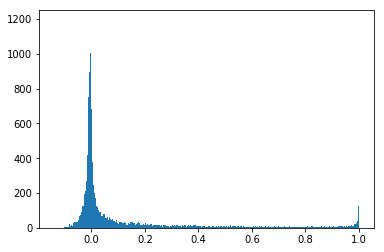

In [53]:
import matplotlib.pyplot as plt
plt.hist((call_y_test - np.reshape(call_y_test_bs, call_y_test_bs.shape[0])) / call_y_test, bins=1000)
plt.ylim(0, 1250)

(-1, 1)

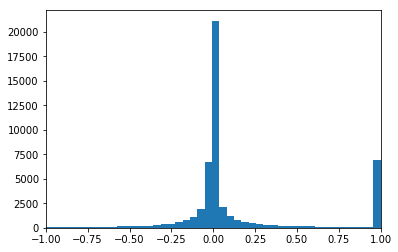

In [59]:
plt.hist((call_y_test - np.reshape(call_y_test_mlp, call_y_test_mlp.shape[0])) / call_y_test, bins=1000)
plt.xlim(-1, 1)

# Error check

In [29]:
call_y_test.head(20)

307405        7.125
6204720     776.950
1841257      36.000
3004299      12.050
8365934     120.350
4280324      24.750
3426613     284.550
3438597       4.250
1129483       2.750
3432672     249.850
7594353       7.600
7652612      42.000
8333974     453.800
7754811    1026.600
1255487     430.500
1881050      44.200
2345660     473.650
7347958       0.675
5560048      31.550
7005014     132.400
dtype: float64

In [30]:
['{0:.3f}'.format(i) for i in call_y_test_bs[:20]]

['0.000',
 '777.310',
 '0.387',
 '0.000',
 '113.354',
 '7.655',
 '290.311',
 '0.000',
 '0.000',
 '251.226',
 '0.000',
 '12.009',
 '457.186',
 '1117.970',
 '468.881',
 '0.000',
 '475.533',
 '0.000',
 '0.000',
 '113.225']

# OLD

In [22]:
'test set mse', np.mean(np.square(call_y_test - np.reshape(call_y_pred, call_y_pred.shape[0])))

('test set mse', 60.14225438740651)

# Now beyond 100 epochs using 1e-6 lr

In [23]:
model.compile(loss='mse', optimizer=Adam(lr=1e-6))

In [24]:
history = model.fit(call_X_train, call_y_train, 
                    batch_size=n_batch, epochs=20, 
                    validation_split = 0.01,
                    callbacks=[TensorBoard()],
                    verbose=1)

Train on 5001241 samples, validate on 50518 samples
Epoch 1/20
5001241/5001241 [==============================] - 34s 7us/step - loss: 53.6987 - val_loss: 52.2438
Epoch 2/20
5001241/5001241 [==============================] - 34s 7us/step - loss: 53.6462 - val_loss: 52.2117
Epoch 3/20
5001241/5001241 [==============================] - 34s 7us/step - loss: 53.6000 - val_loss: 52.1503
Epoch 4/20
5001241/5001241 [==============================] - 34s 7us/step - loss: 53.5716 - val_loss: 52.5116
Epoch 5/20
5001241/5001241 [==============================] - 34s 7us/step - loss: 53.5317 - val_loss: 52.7806
Epoch 6/20
5001241/5001241 [==============================] - 34s 7us/step - loss: 53.5112 - val_loss: 52.1189
Epoch 7/20
5001241/5001241 [==============================] - 34s 7us/step - loss: 53.5029 - val_loss: 52.6333
Epoch 8/20
5001241/5001241 [==============================] - 34s 7us/step - loss: 53.4770 - val_loss: 52.2363
Epoch 9/20
5001241/5001241 [==============================] 

KeyboardInterrupt: 

In [25]:
model.save('mlp1-110.h5')

In [26]:
call_y_pred2 = model.predict(call_X_test)
'test set mse', np.mean(np.square(call_y_test - np.reshape(call_y_pred2, call_y_pred2.shape[0])))

('test set mse', 53.73220293447192)

# Now 1e-7 lr

In [27]:
model.compile(loss='mse', optimizer=Adam(lr=1e-7))

In [28]:
history = model.fit(call_X_train, call_y_train, 
                    batch_size=n_batch, epochs=10, 
                    validation_split = 0.01,
                    callbacks=[TensorBoard()],
                    verbose=1)

Train on 5001241 samples, validate on 50518 samples
Epoch 1/10
5001241/5001241 [==============================] - 35s 7us/step - loss: 53.1470 - val_loss: 51.8260
Epoch 2/10
5001241/5001241 [==============================] - 34s 7us/step - loss: 53.1357 - val_loss: 51.8296
Epoch 3/10
5001241/5001241 [==============================] - 34s 7us/step - loss: 53.1348 - val_loss: 51.8111
Epoch 4/10
5001241/5001241 [==============================] - 34s 7us/step - loss: 53.1323 - val_loss: 51.8094
Epoch 5/10
5001241/5001241 [==============================] - 34s 7us/step - loss: 53.1289 - val_loss: 51.8534
Epoch 6/10
 152576/5001241 [..............................] - ETA: 38s - loss: 52.8562

KeyboardInterrupt: 

In [29]:
model.save('mlp1-115.h5')
call_y_pred3 = model.predict(call_X_test)
'test set mse', np.mean(np.square(call_y_test - np.reshape(call_y_pred3, call_y_pred3.shape[0])))

('test set mse', 53.5843140261273)

# Now 1e-8 lr

In [30]:
model.compile(loss='mse', optimizer=Adam(lr=1e-8))
history = model.fit(call_X_train, call_y_train, 
                    batch_size=n_batch, epochs=5, 
                    validation_split = 0.01,
                    callbacks=[TensorBoard()],
                    verbose=1)

Train on 5001241 samples, validate on 50518 samples
Epoch 1/5
5001241/5001241 [==============================] - 37s 7us/step - loss: 53.0968 - val_loss: 51.7894
Epoch 2/5
5001241/5001241 [==============================] - 36s 7us/step - loss: 53.0941 - val_loss: 51.7931
Epoch 3/5
5001241/5001241 [==============================] - 36s 7us/step - loss: 53.0935 - val_loss: 51.7934
Epoch 4/5
5001241/5001241 [==============================] - 37s 7us/step - loss: 53.0932 - val_loss: 51.7975
Epoch 5/5
5001241/5001241 [==============================] - 37s 7us/step - loss: 53.0932 - val_loss: 51.7929


In [31]:
model.save('mlp1-120.h5')
call_y_pred4 = model.predict(call_X_test)
'test set mse', np.mean(np.square(call_y_test - np.reshape(call_y_pred4, call_y_pred4.shape[0])))

('test set mse', 53.54766449036366)